<a href="https://colab.research.google.com/github/fatch01/MalatyaDam/blob/main/MalatyaDamipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Google Drive bağlantısı için gerekli kütüphane
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install opencv-python matplotlib tensorflow numpy

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# **Görüntü Yükleme ve Ön İşleme**

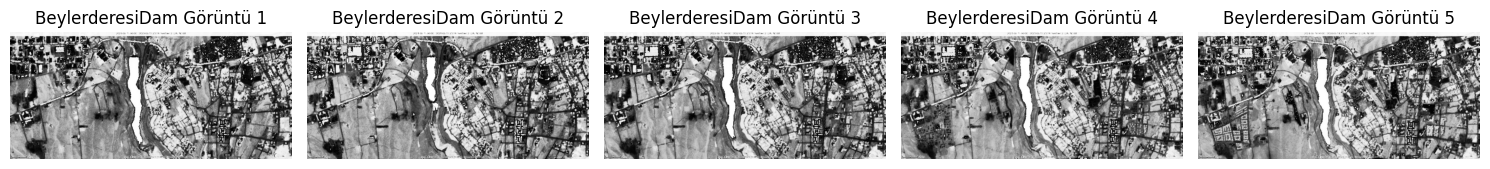

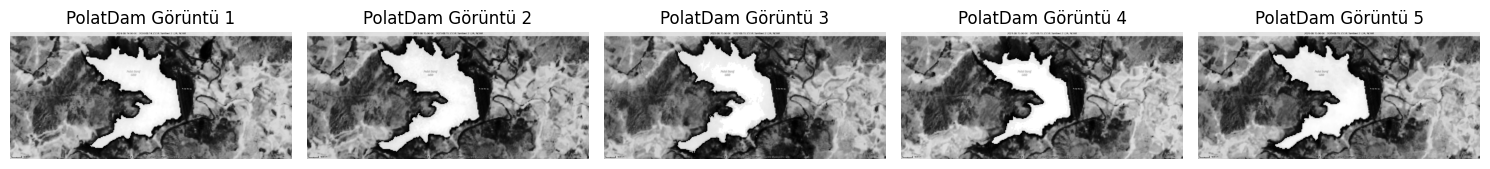

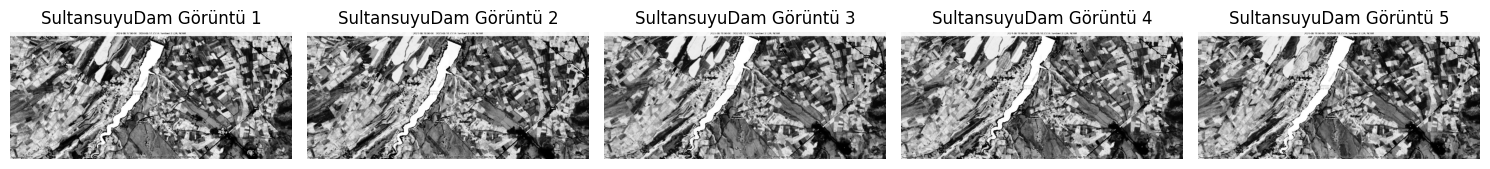

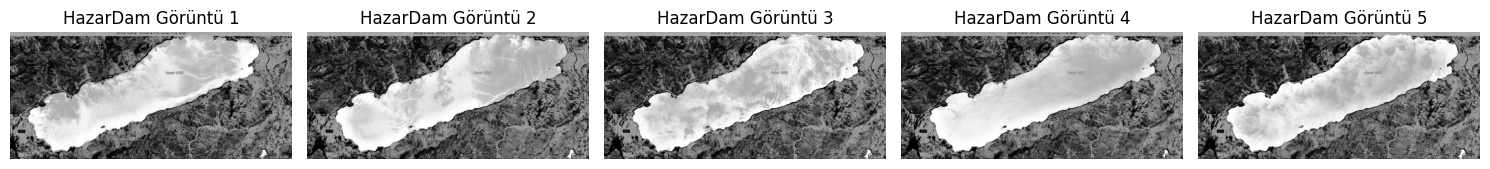

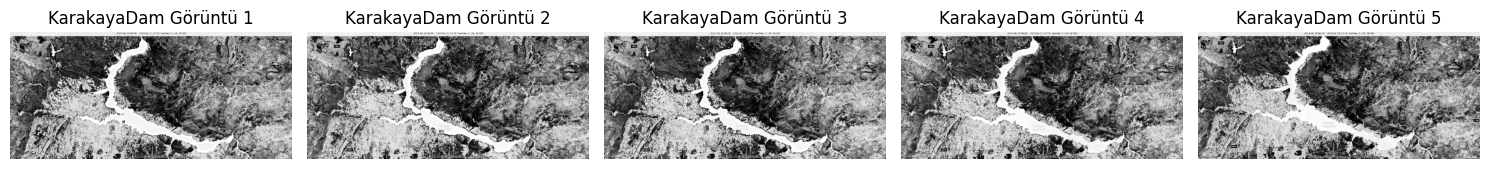

In [ ]:
def load_image(file_path: str):
    """PNG görüntüsünü yükler ve normalize eder."""
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)  # Gri ölçekli yükle
    if image is None:
        raise FileNotFoundError(f"Görüntü yüklenemedi: {file_path}")
    return image / 255.0  # Normalize et

def load_images_from_folder(folder: str):
    """Belirtilen klasörden tüm görüntüleri yükler."""
    images = []
    for filename in os.listdir(folder):
        img = load_image(os.path.join(folder, filename))
        images.append(img)
    return np.array(images)

def preprocess_images(base_folder: str):
    """Tüm dam görüntülerini yükler ve ön işler."""
    all_images = {}
    dam_folders = ["BeylerderesiDam", "PolatDam", "SultansuyuDam", "HazarDam", "KarakayaDam"]
    for dam in dam_folders:
        folder_path = os.path.join(base_folder, dam)
        all_images[dam] = load_images_from_folder(folder_path)
    return all_images

def denoise_image(image: np.ndarray, kernel_size: int = 3) -> np.ndarray:
    """Görüntüdeki gürültüyü median filtre ile temizler."""
    if len(image.shape) != 2:  # Kontrol et: görüntü 2D olmalı
        raise ValueError("Görüntü 2D formatında olmalıdır.")
    return cv2.medianBlur((image * 255).astype('uint8'), kernel_size)

def enhance_contrast(image: np.ndarray) -> np.ndarray:
    """Görüntünün kontrastını artırmak için histogram eşitlemesi uygular."""
    return cv2.equalizeHist((image * 255).astype('uint8')) / 255.0

def process_all_images(dam_images: dict):
    """Tüm damlar için gürültü temizleme ve kontrast artırma işlemlerini yapar."""
    for dam in dam_images:
        for i in range(len(dam_images[dam])):
            cleaned_image = denoise_image(dam_images[dam][i])  # Gürültü temizleme
            dam_images[dam][i] = enhance_contrast(cleaned_image)  # Kontrast artırma

def visualize_images(images: np.ndarray, dam_name: str):
    """Görüntüleri yan yana görselleştirir."""
    plt.figure(figsize=(15, 5))
    for i in range(min(5, len(images))):  # En fazla 5 görüntü göster
        plt.subplot(1, 5, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f"{dam_name} Görüntü {i + 1}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Klasör yolunu tanımlayın
base_folder = "/content/name"

# Tüm görüntüleri yükleyin
dam_images = preprocess_images(base_folder)

# Tüm görüntüler üzerinde ön işleme yapın
process_all_images(dam_images)

# İşlenmiş görüntüleri görselleştir
for dam in dam_images.keys():
    visualize_images(dam_images[dam], dam)

# **Etiketleme İşlemi**

In [ ]:
# Koyu mavi alanları tespit eden fonksiyon
def detect_reservoir_regions(image_bgr: np.ndarray) -> np.ndarray:
    """
    Görüntüde koyu mavi (baraj) alanlarını tespit eder.
    """
    if len(image_bgr.shape) != 3 or image_bgr.shape[2] != 3:
        raise ValueError("Girdi görüntüsü BGR formatında olmalıdır!")

    # Koyu mavi renk aralığı (BGR formatında)
    lower_blue = np.array([50, 0, 0])  # Daha düşük sınırı azalt
    upper_blue = np.array([255, 120, 120])  # Daha geniş aralık tanımla

    # Koyu mavi alanları tespit etmek için maske oluştur
    blue_mask = cv2.inRange(image_bgr, lower_blue, upper_blue)
    return blue_mask

# Görüntüyü renklendiren fonksiyon
def generate_mask_with_colors(image_bgr: np.ndarray, blue_mask: np.ndarray) -> np.ndarray:
    """
    Koyu mavi alanları mavi, diğer bölgeleri kırmızı renklendirir.
    """
    colored_mask = np.zeros_like(image_bgr)
    colored_mask[blue_mask > 0] = [255, 0, 0]  # Su alanları mavi
    colored_mask[blue_mask == 0] = [0, 0, 255]  # Diğer alanlar kırmızı
    return colored_mask

# Her klasör için işlem yap
base_path = "/content/name"
dam_names = ["BeylerderesiDam", "PolatDam", "SultansuyuDam", "HazarDam", "KarakayaDam"]

for dam in dam_names:
    dam_path = os.path.join(base_path, dam)
    output_path = os.path.join(dam_path, "Processed")
    os.makedirs(output_path, exist_ok=True)

    for img_name in os.listdir(dam_path):
        img_path = os.path.join(dam_path, img_name)
        output_file = os.path.join(output_path, f"processed_{img_name}")

        # Görüntüyü yükle
        original_image = cv2.imread(img_path)
        if original_image is None:
            print(f"Görüntü yüklenemedi: {img_name}")
            continue

        # Koyu mavi alanları tespit et
        blue_mask = detect_reservoir_regions(original_image)

        # Renklendirilmiş maske oluştur
        colored_mask = generate_mask_with_colors(original_image, blue_mask)

        # Çıktıyı kaydet
        cv2.imwrite(output_file, colored_mask)
        print(f"İşlenmiş görüntü kaydedildi: {output_file}")


Görselleştirilen baraj: BeylerderesiDam


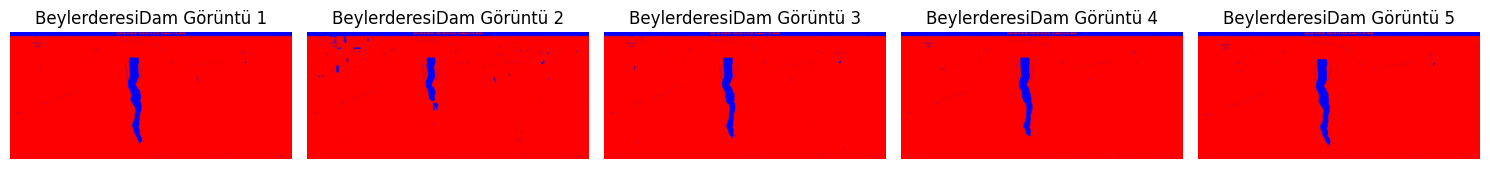

Görselleştirilen baraj: PolatDam


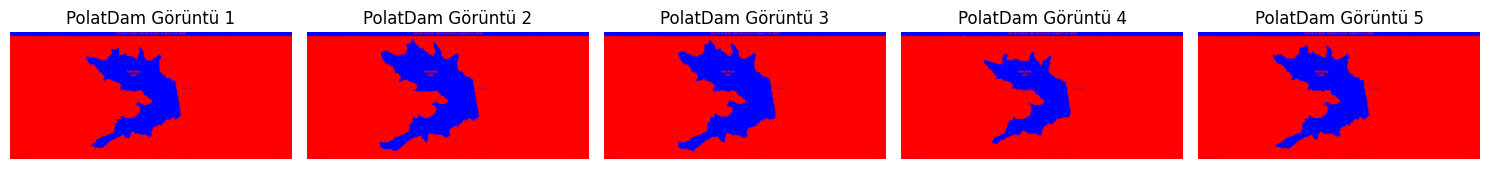

Görselleştirilen baraj: SultansuyuDam


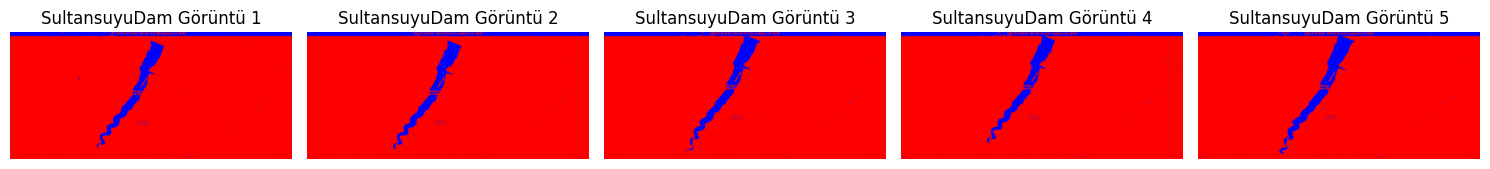

Görselleştirilen baraj: HazarDam


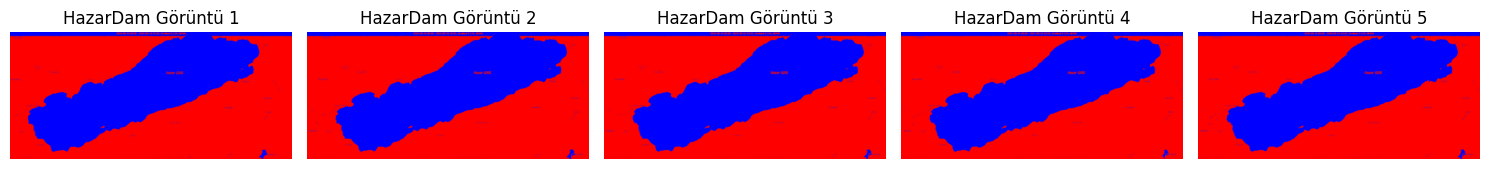

Görselleştirilen baraj: KarakayaDam


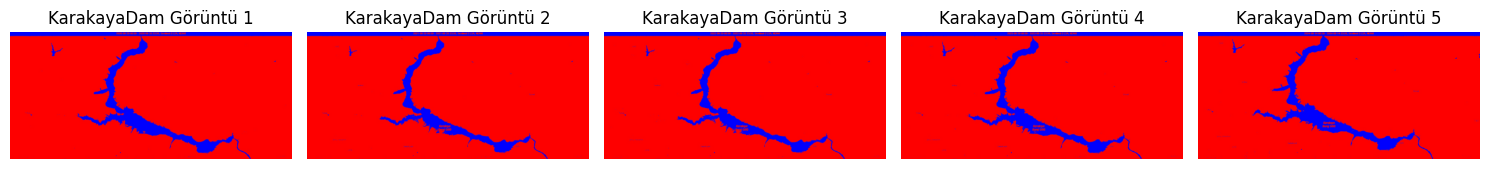

In [ ]:
# İşlenmiş görüntüleri görselleştirme fonksiyonu
def visualize_processed_images(base_path, dam_names):
    """
    İşlenmiş görüntüleri her baraj için görselleştirir.
    """
    for dam in dam_names:
        processed_path = os.path.join(base_path, dam, "Processed")
        if not os.path.exists(processed_path):
            print(f"İşlenmiş klasör bulunamadı: {processed_path}")
            continue

        print(f"Görselleştirilen baraj: {dam}")
        processed_images = os.listdir(processed_path)

        # Görselleştir
        plt.figure(figsize=(15, 10))
        for i, img_name in enumerate(processed_images[:5]):  # İlk 5 resmi göster
            img_path = os.path.join(processed_path, img_name)
            processed_image = cv2.imread(img_path)

            if processed_image is None:
                print(f"Görüntü yüklenemedi: {img_name}")
                continue

            # Görselleştirilen görseli RGB formatına çevir
            plt.subplot(1, 5, i + 1)
            plt.imshow(cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB))
            plt.title(f"{dam} Görüntü {i + 1}")
            plt.axis("off")

        plt.tight_layout()
        plt.show()

# Görselleştirme işlemini çalıştır
visualize_processed_images(base_path, dam_names)

# **Eğitim ve Test Veri Setini Bölme**

In [ ]:
# NDWI eşikleme fonksiyonu
def threshold_ndwi(image: np.ndarray, threshold: float = 0.3) -> np.ndarray:
    """
    Görüntüyü NDWI eşikleme ile su ve kara olarak ayırır.
    """
    return np.where(image > threshold, 1, 0)  # Su = 1, Kara = 0

# Her dam için etiketleme işlemi
masks = {}
for dam in dam_images:
    masks[dam] = []
    for img in dam_images[dam]:
        mask = threshold_ndwi(img)  # Eşikleme işlemi
        masks[dam].append(mask)
    masks[dam] = np.array(masks[dam])

# Maskelerin oluşturulduğunu kontrol etme
for dam in masks:
    print(f"{dam} için maske sayısı: {len(masks[dam])}")

# Maskelerin boyutunu kontrol et
print("Maske boyutları:")
for dam in masks:
    if masks[dam].size > 0:
        print(f"{dam} maskesi: {masks[dam].shape}")
    else:
        print(f"{dam} maskesi: Boş")

# Eğitim ve test veri setlerini ayırın
X = np.concatenate([dam_images[dam] for dam in dam_images.keys()])
y = np.concatenate([masks[dam] for dam in masks.keys()])

# Eğitim ve test veri setlerini ayırın
if len(X) > 0 and len(y) > 0:
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
else:
    print("Hata: Eğitim ve etiket dizileri boş.")

BeylerderesiDam için maske sayısı: 5
PolatDam için maske sayısı: 5
SultansuyuDam için maske sayısı: 5
HazarDam için maske sayısı: 5
KarakayaDam için maske sayısı: 5
Maske boyutları:
BeylerderesiDam maskesi: (5, 694, 1536)
PolatDam maskesi: (5, 694, 1536)
SultansuyuDam maskesi: (5, 694, 1536)
HazarDam maskesi: (5, 694, 1536)
KarakayaDam maskesi: (5, 694, 1536)


In [ ]:
# Verileri normalize et
X = np.expand_dims(X, axis=-1)  # Kanal boyutunu ekle
y = np.expand_dims(y, axis=-1)  # Kanal boyutunu ekle

# Eğitim ve test veri setlerini ayır
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")


X_train: (20, 694, 1536, 1), y_train: (20, 694, 1536, 1)
X_val: (5, 694, 1536, 1), y_val: (5, 694, 1536, 1)


# **U-Net Modelini Tanımlama**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
# Eğitim verilerini tanımlama
num_samples = 20  # Örnek sayısı, ihtiyacınıza göre ayarlayın
height = 256       # U-Net için uygun bir yükseklik (çift sayı)
width = 256       # Görüntü genişliği
channels = 1       # Tek kanal (gri tonlama)

# Rastgele eğitim verisi oluşturma
X = np.random.rand(num_samples, height, width, channels)  # (num_samples, height, width, channels)

# Rastgele etiket verisi oluşturma
y = np.random.randint(0, 2, (num_samples, height, width, 1))  # (num_samples, height, width, 1)

# Eğitim ve doğrulama verilerini ayır
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
def build_unet(input_shape):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)

    # Decoder
    u4 = UpSampling2D((2, 2))(c3)
    u4 = concatenate([u4, c2])
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(u4)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(c4)

    u5 = UpSampling2D((2, 2))(c4)
    u5 = concatenate([u5, c1])
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(u5)
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(c5)

    # Çıkış katmanı
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)

    model = Model(inputs, outputs)
    return model

# Modeli oluştur
input_shape = (height, width, channels)  # Modelin giriş boyutu
model = build_unet(input_shape)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 94s 49s/step - accuracy: 0.4996 - loss: 0.6932 - val_accuracy: 0.5010 - val_loss: 0.6932
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 99s 48s/step - accuracy: 0.5005 - loss: 0.6932 - val_accuracy: 0.4995 - val_loss: 0.6932
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 125s 42s/step - accuracy: 0.5005 - loss: 0.6932 - val_accuracy: 0.4991 - val_loss: 0.6932
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 141s 44s/step - accuracy: 0.5014 - loss: 0.6931 - val_accuracy: 0.5009 - val_loss: 0.6932
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 82s 44s/step - accuracy: 0.5016 - loss: 0.6931 - val_accuracy: 0.5003 - val_loss: 0.6931
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 82s 44s/step - accuracy: 0.5017 - loss: 0.6931 - val_accuracy: 0.5006 - val_loss: 0.6931
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 84s 47s/step - accuracy: 0.5016 - loss: 0.6931 - val_accuracy: 0.5007 - val_loss: 0.6931
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 141s 42s/step - accuracy: 0.5025 - loss: 0.6931 - val_accuracy: 0.5015 - val_loss: 0.69

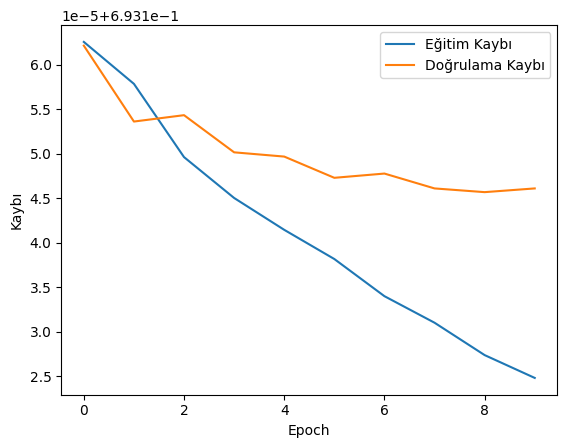

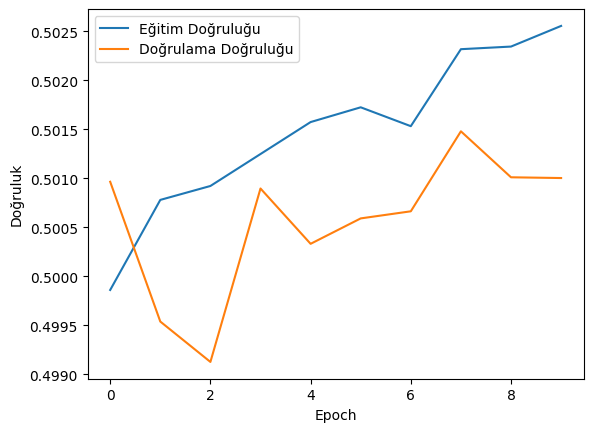

In [ ]:
# Geri çağırmaları tanımla
model_checkpoint = ModelCheckpoint('model_unet.keras', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Modeli eğit
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=8,  # Daha küçük bir batch boyutu
    callbacks=[early_stopping, model_checkpoint]
)
# Eğitim sürecini görselleştir
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kaybı')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.show()

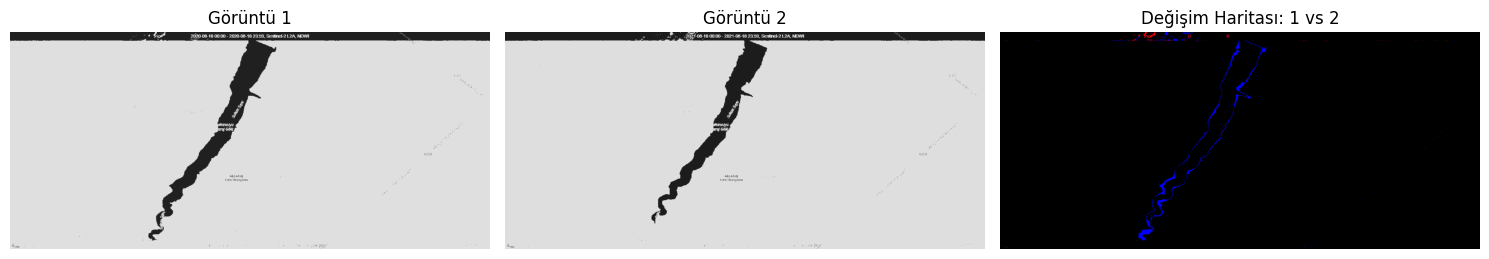

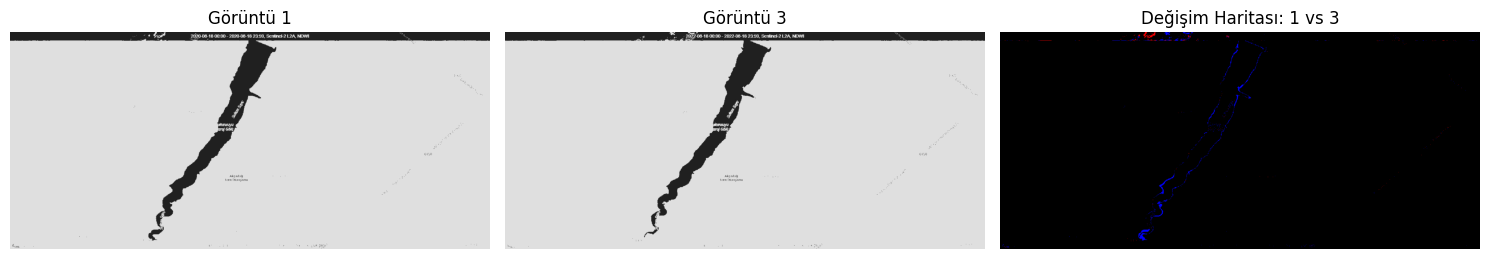

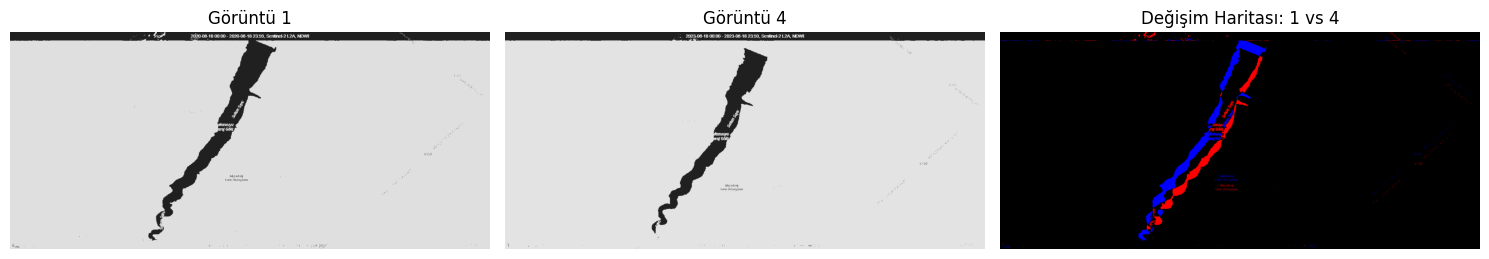

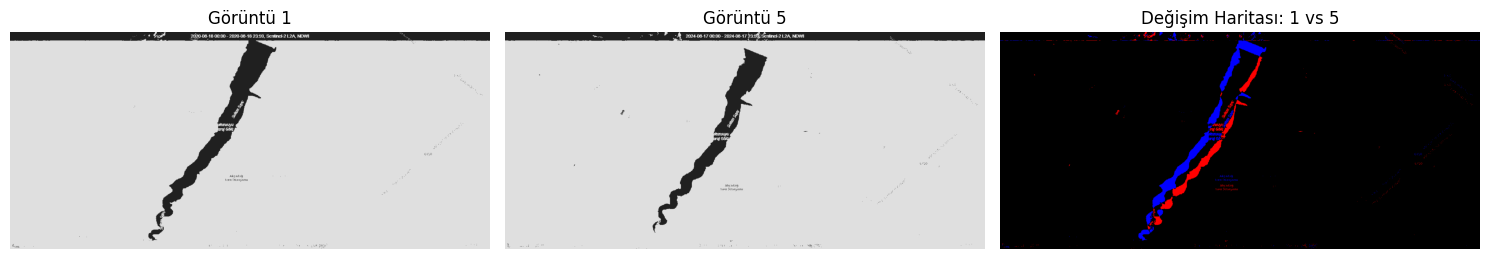

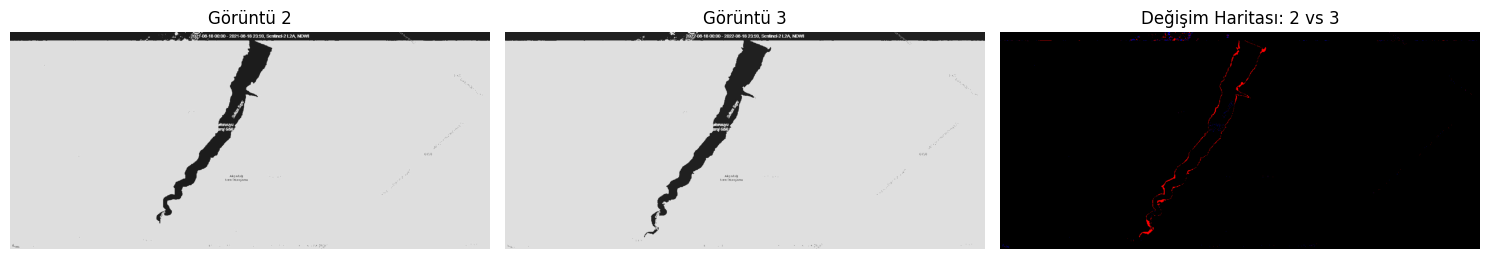

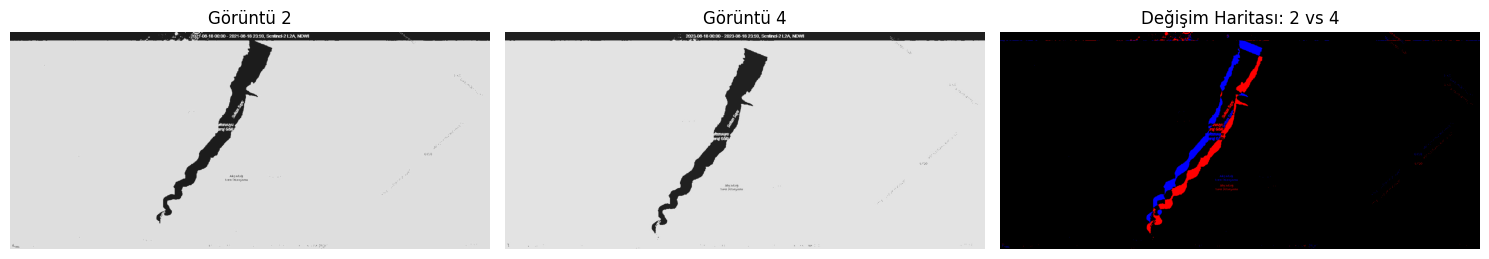

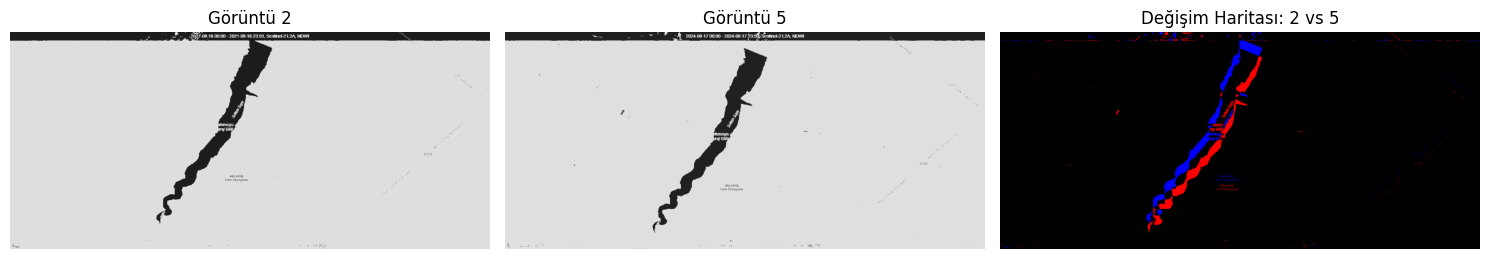

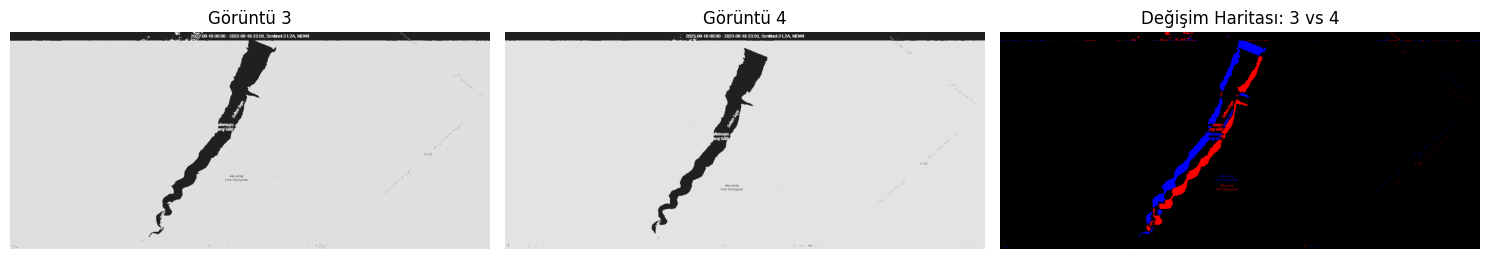

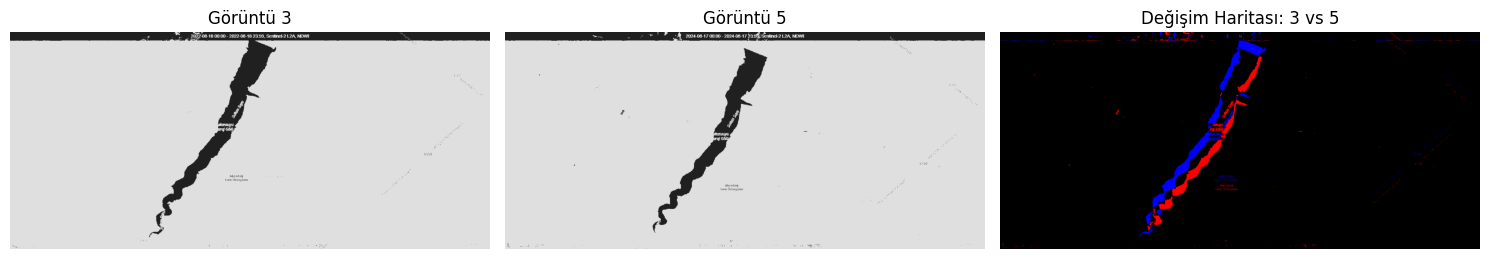

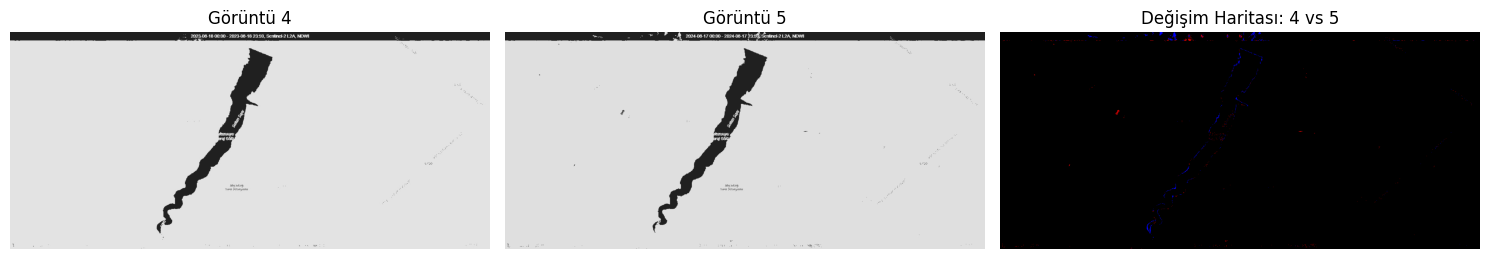

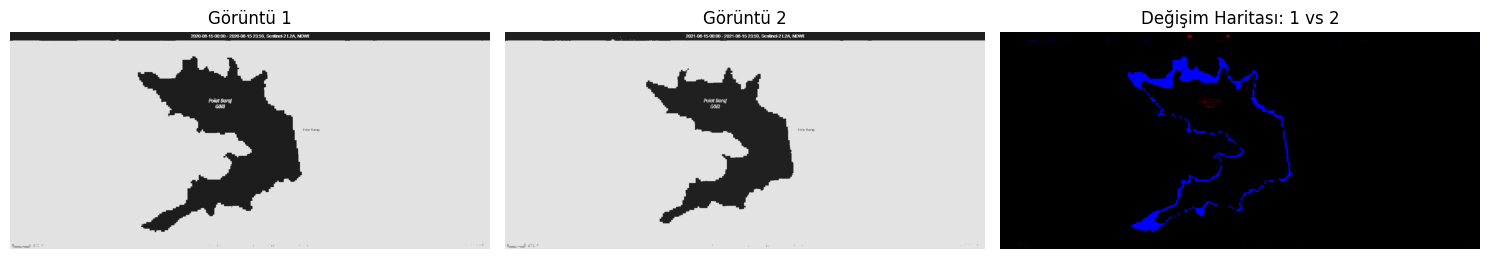

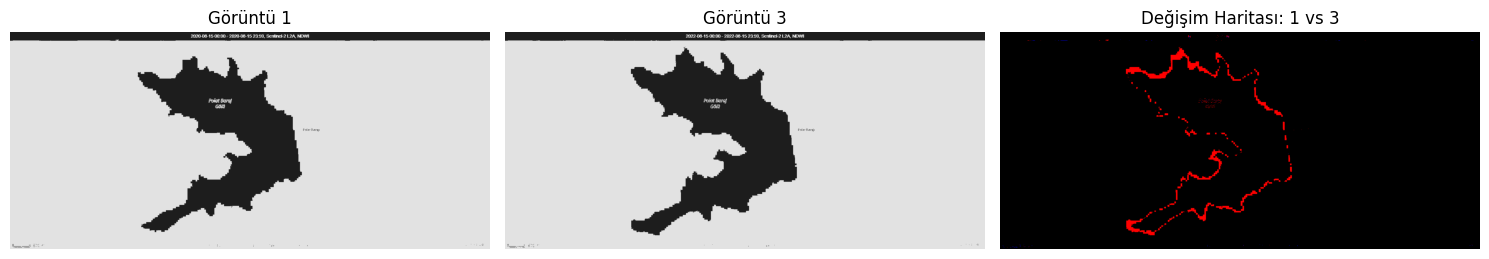

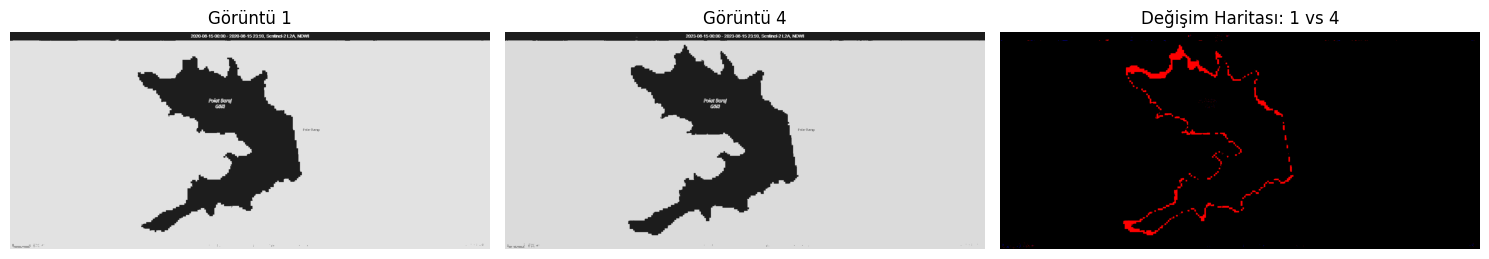

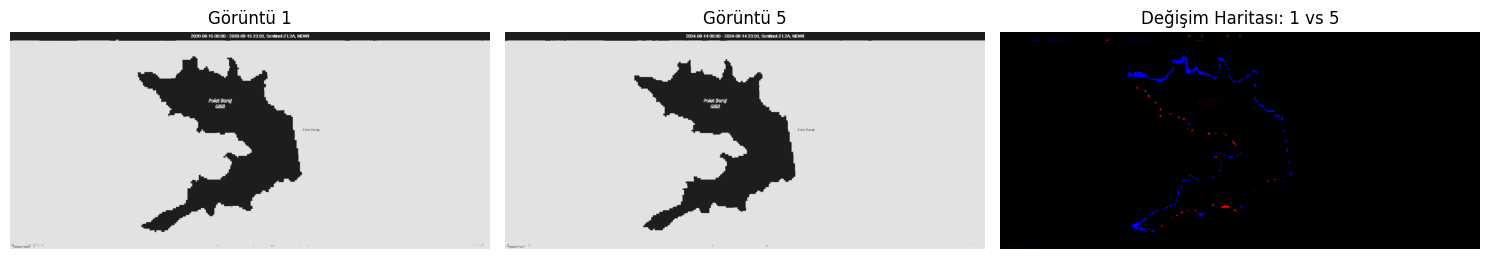

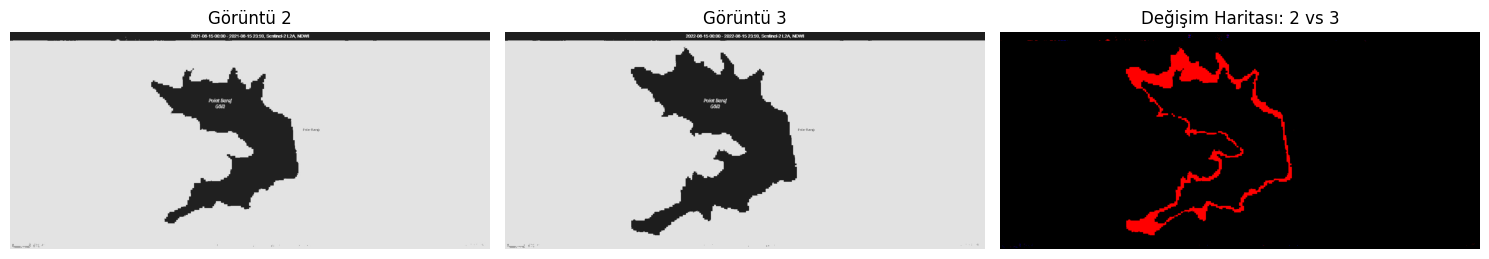

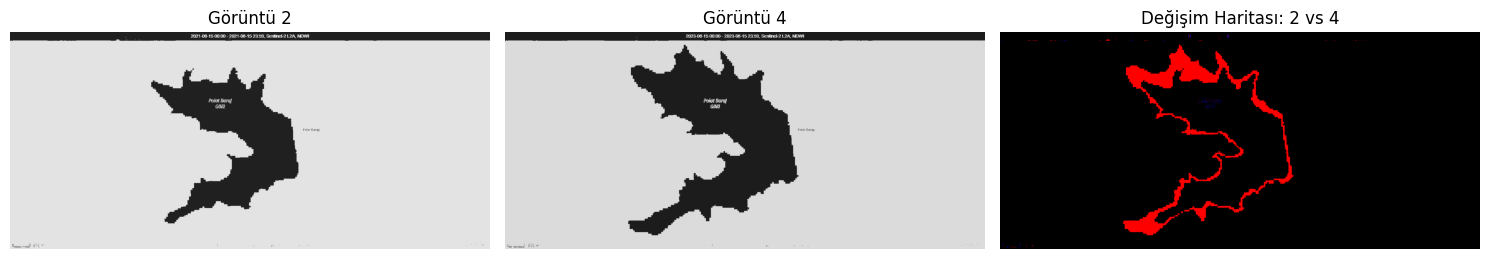

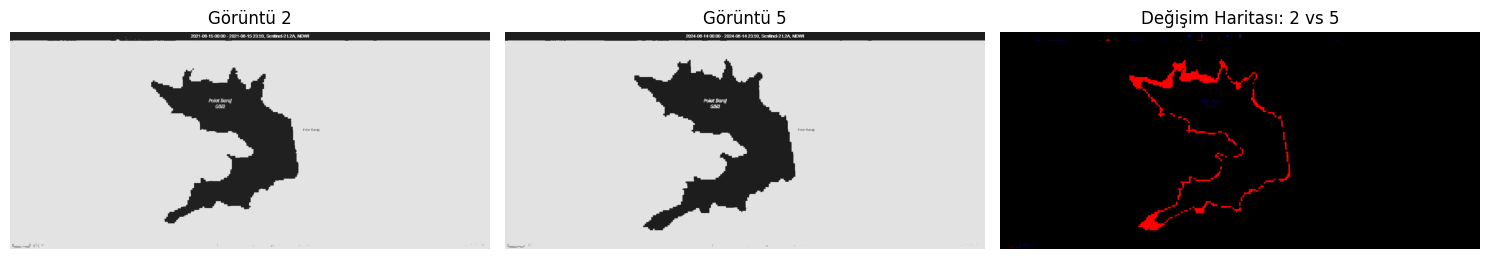

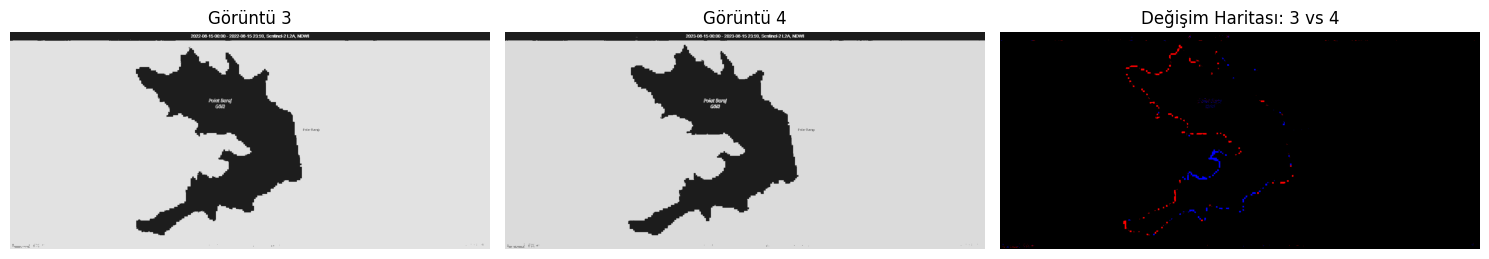

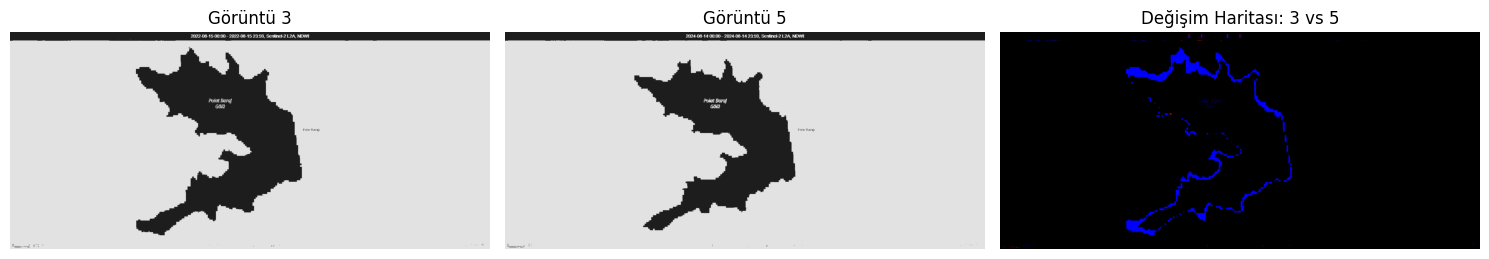

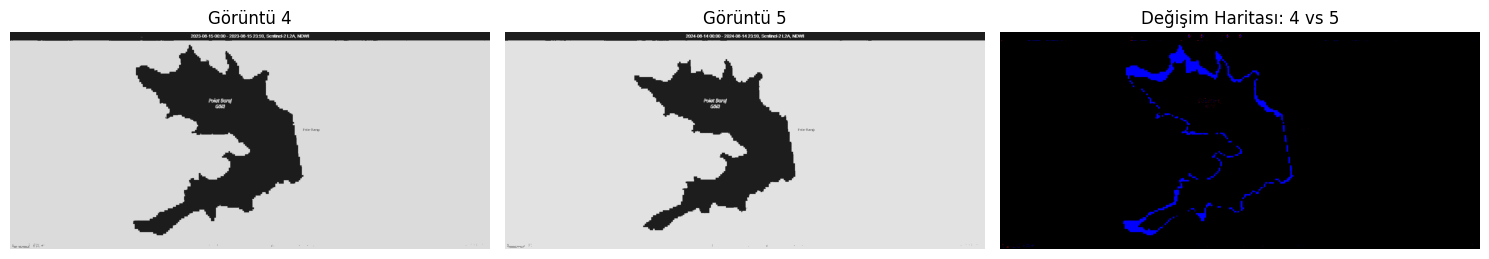

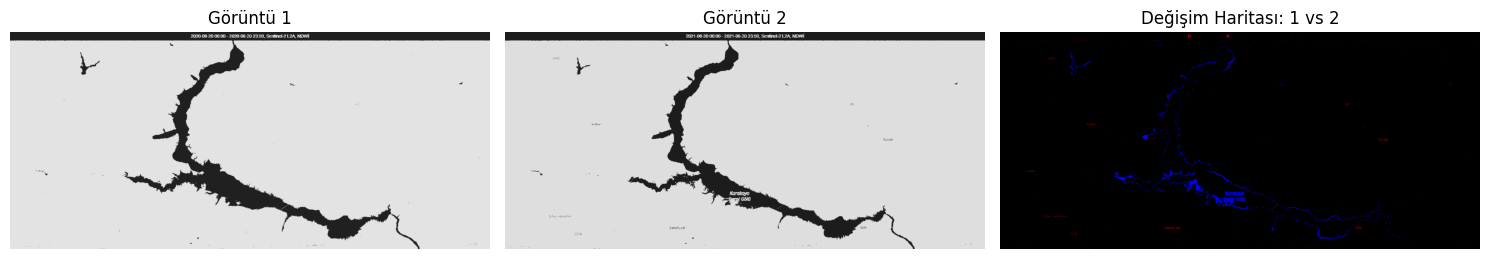

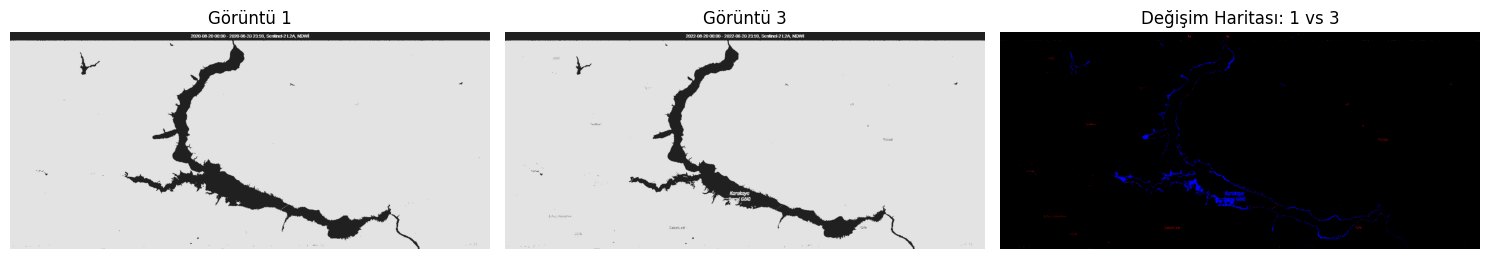

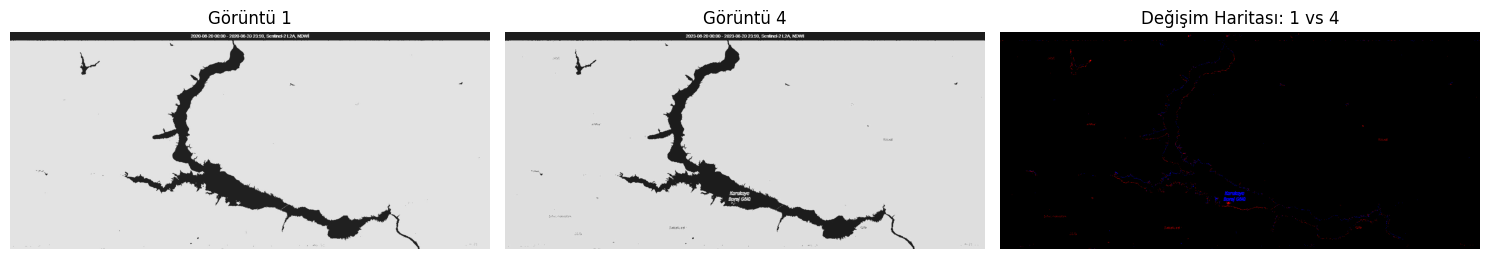

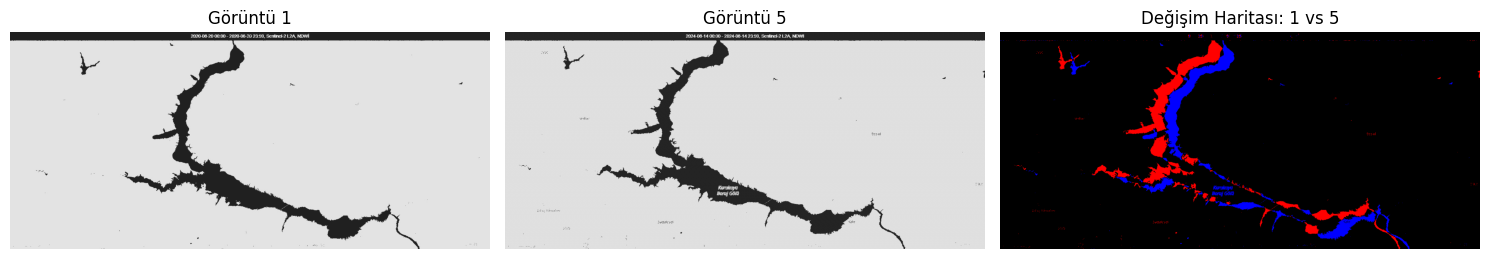

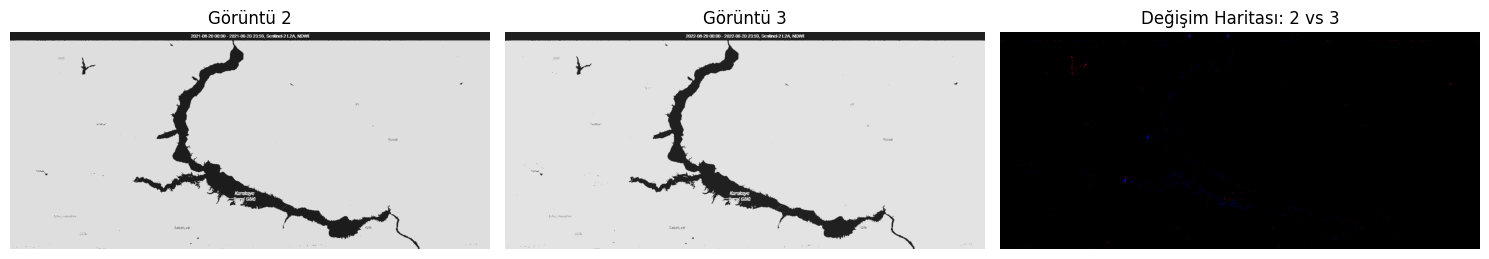

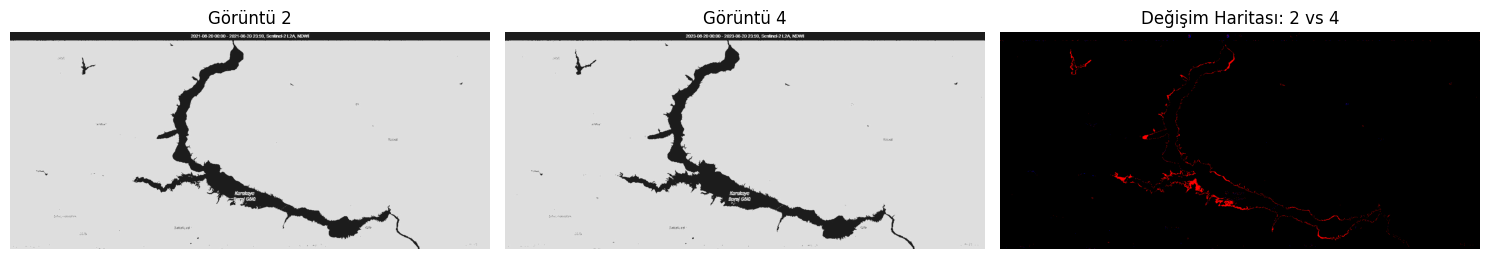

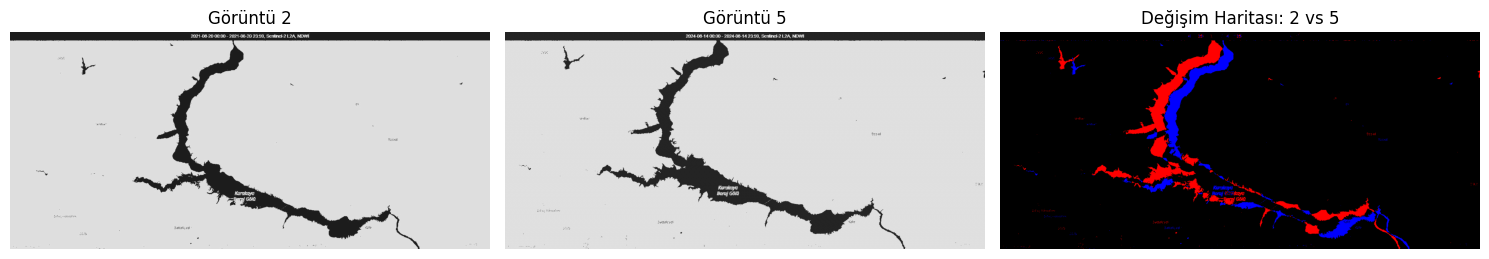

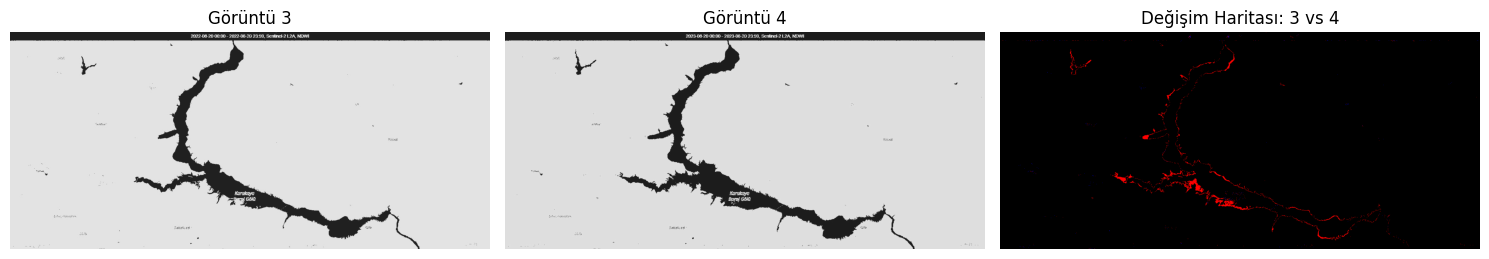

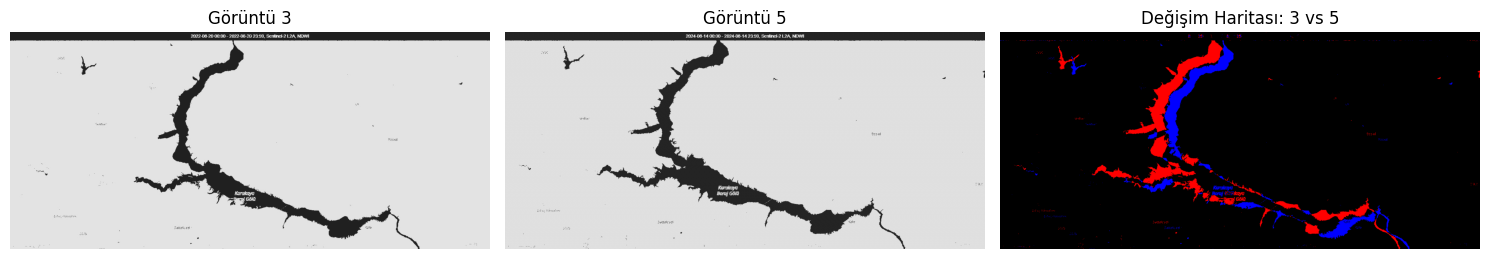

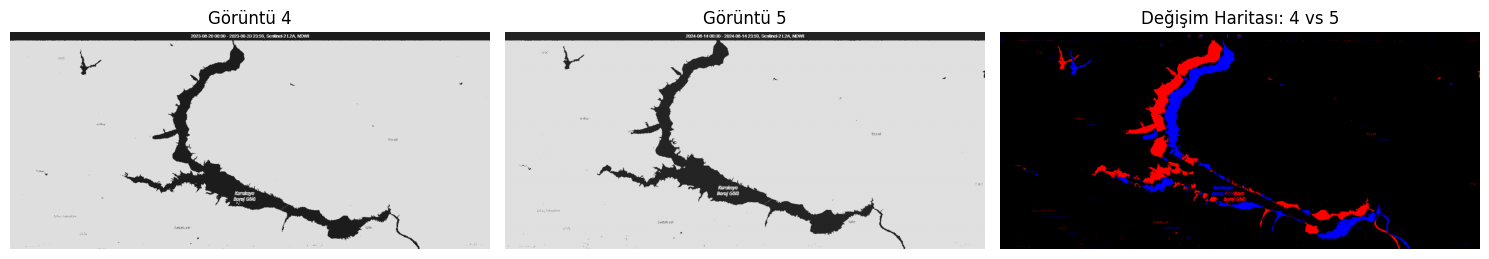

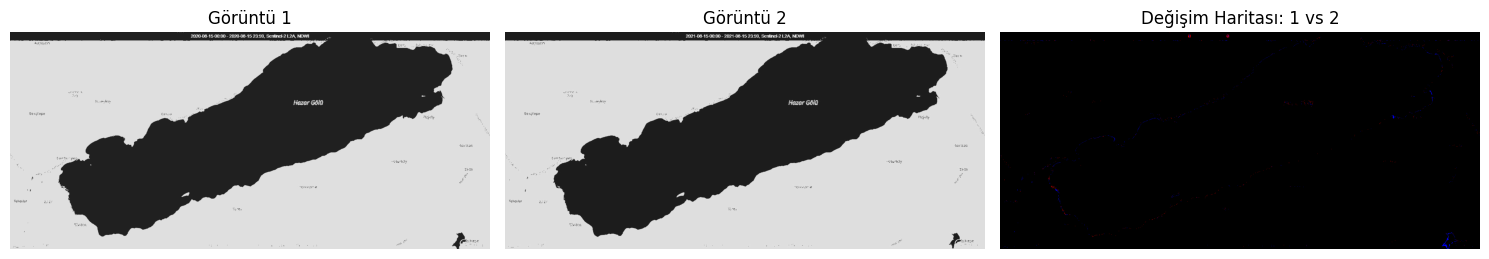

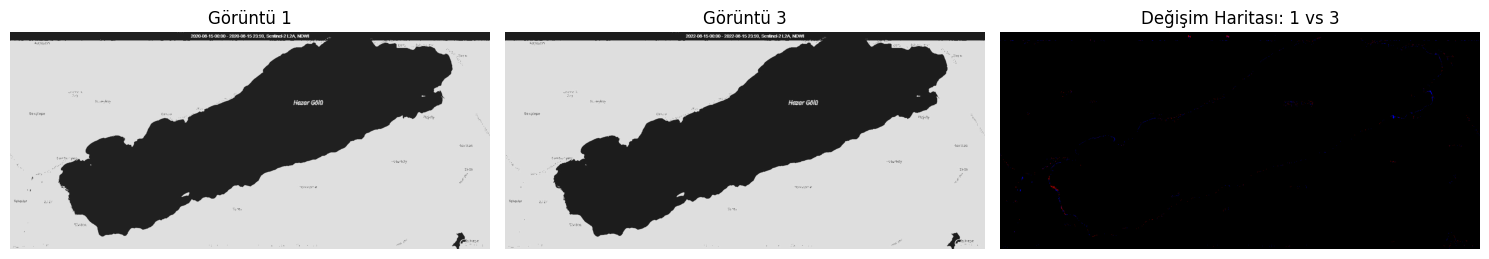

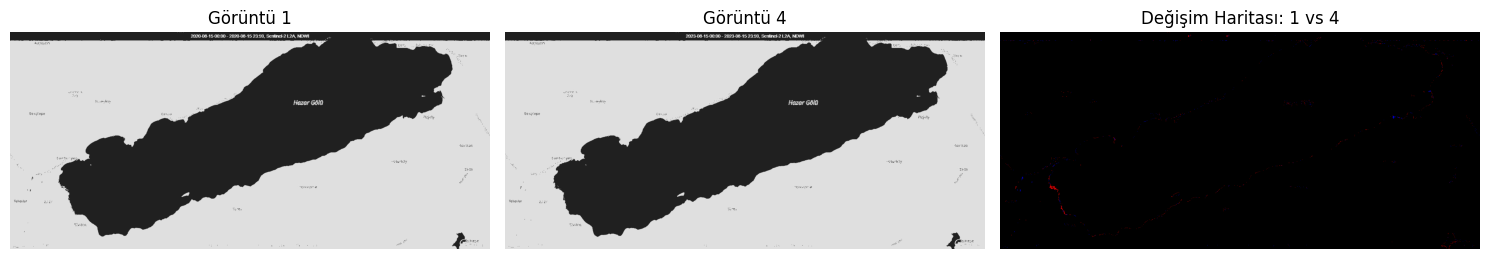

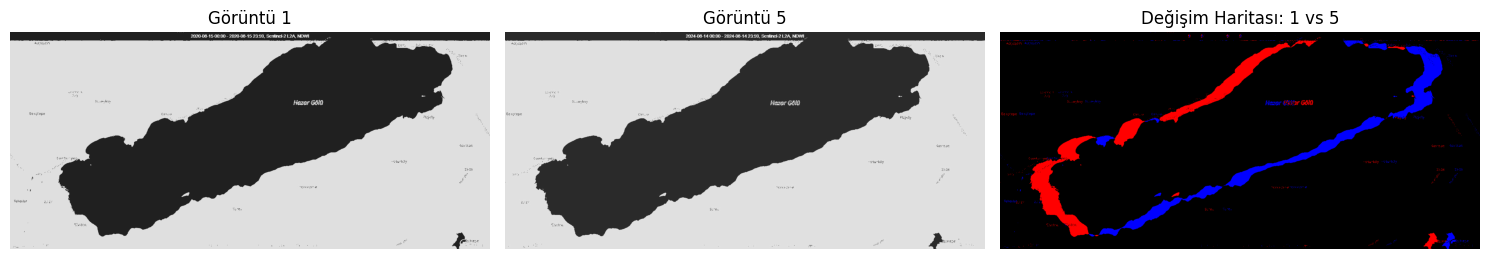

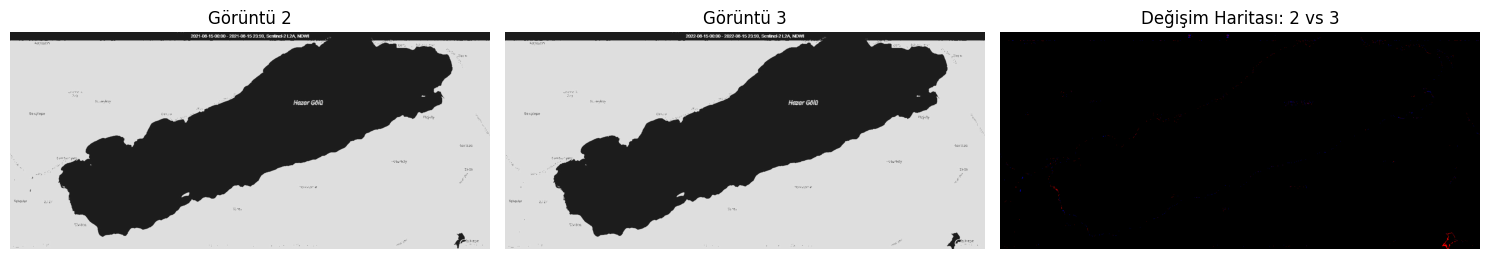

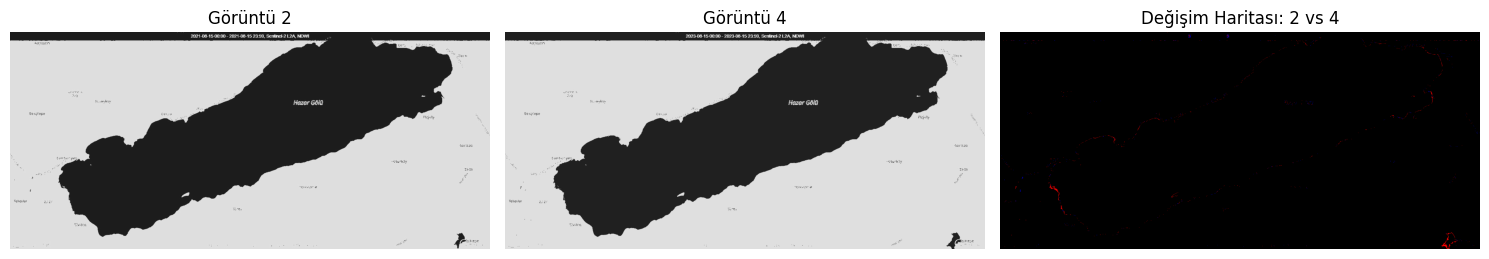

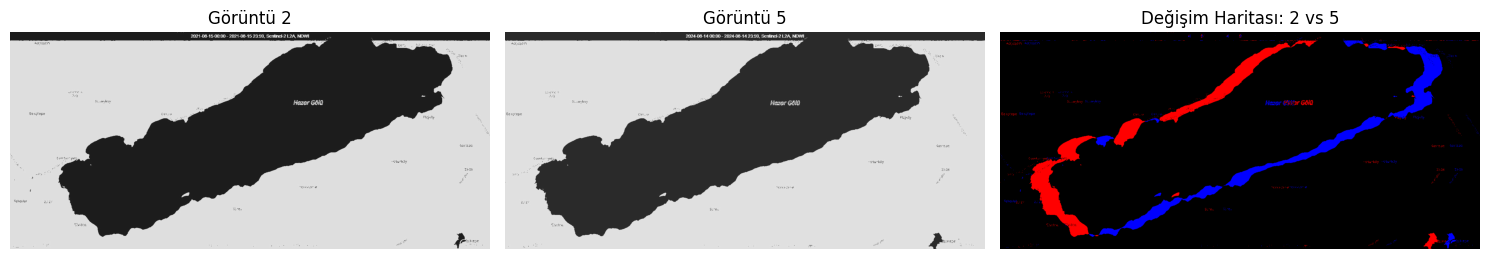

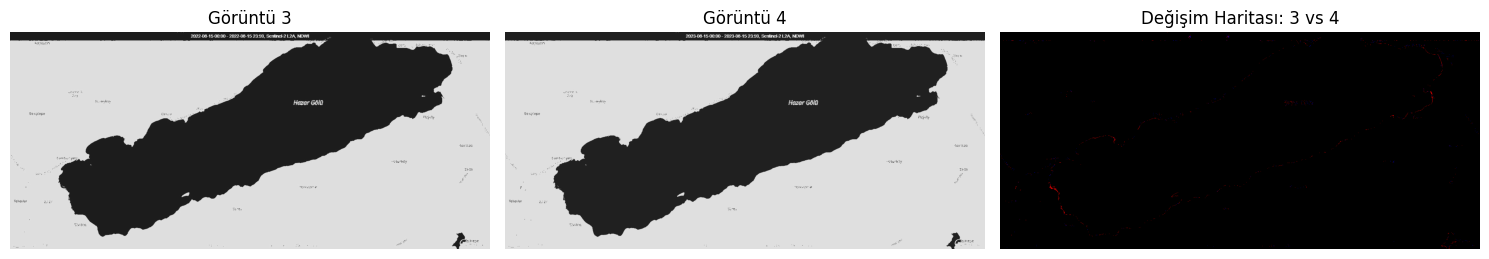

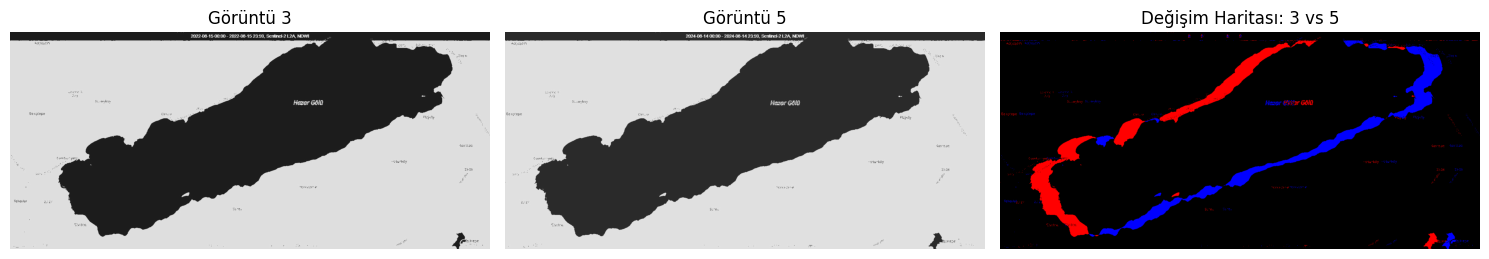

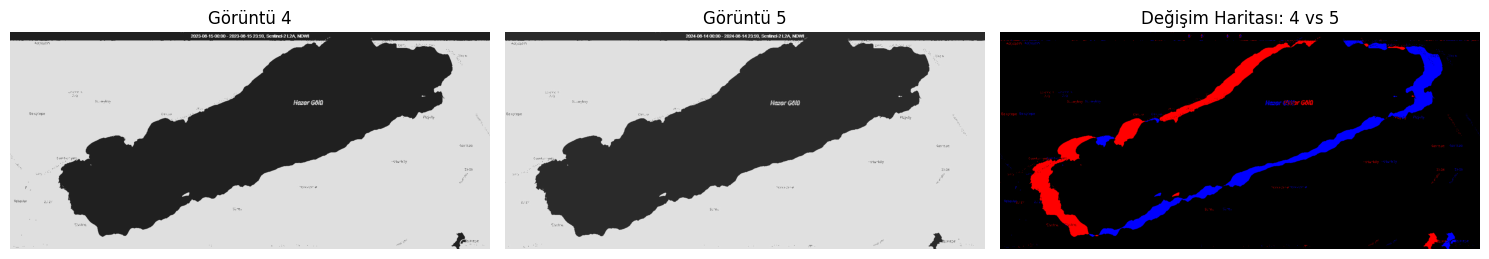

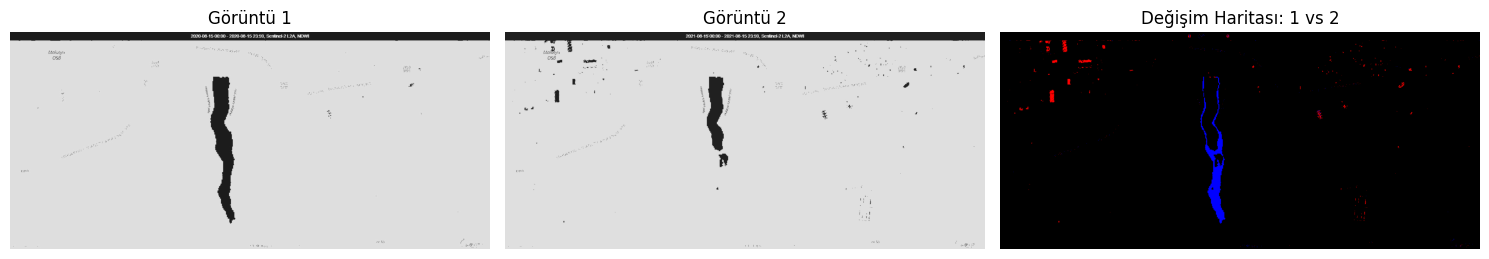

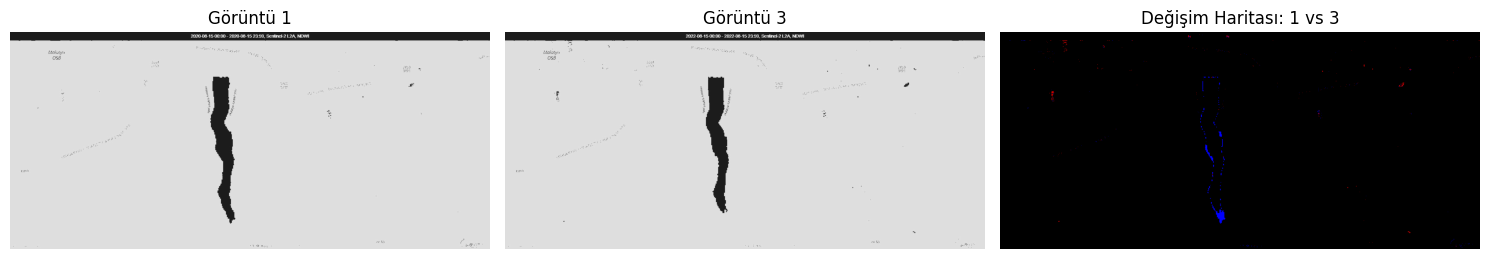

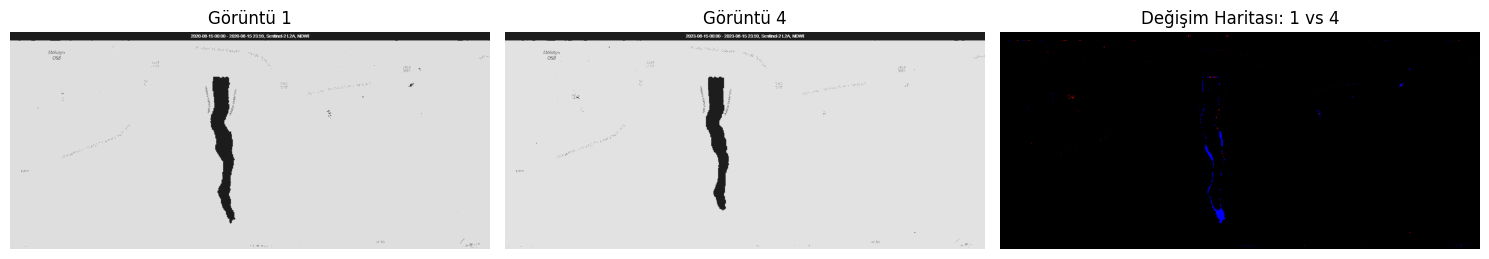

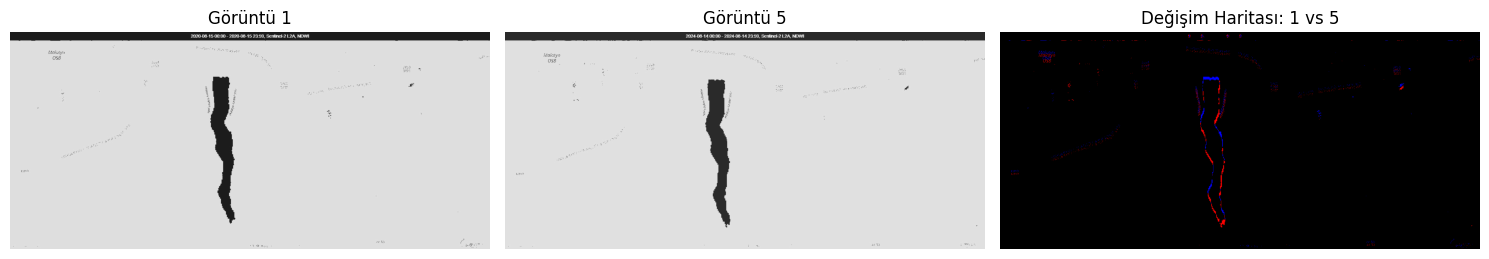

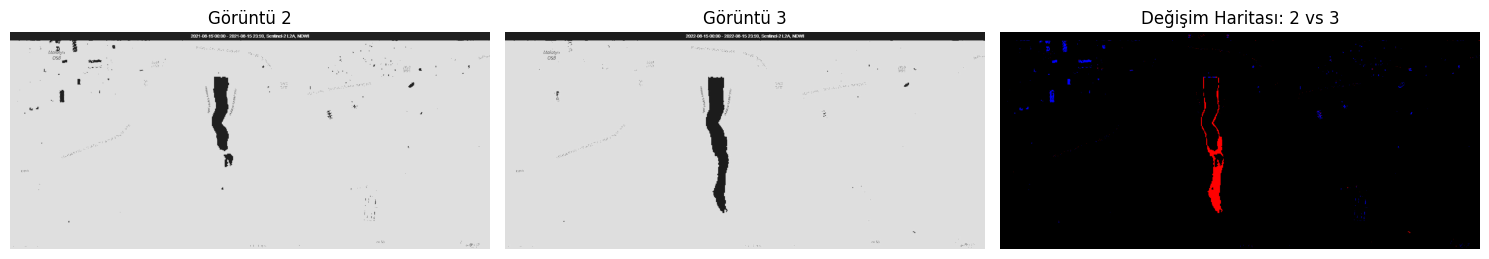

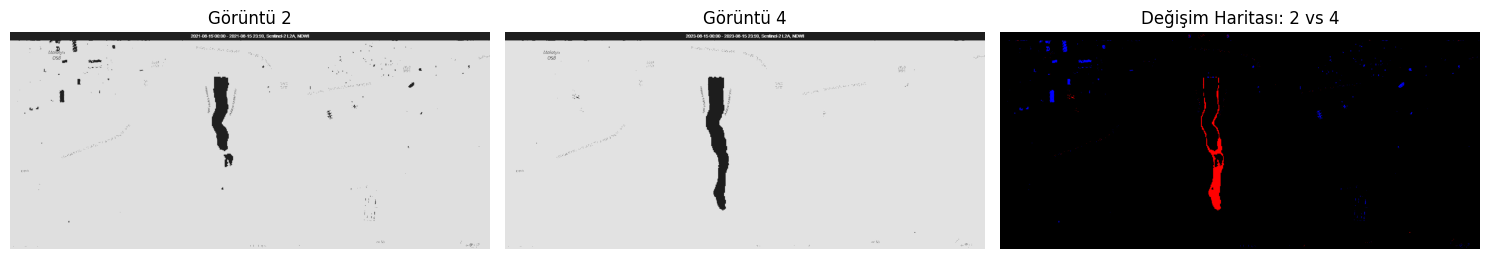

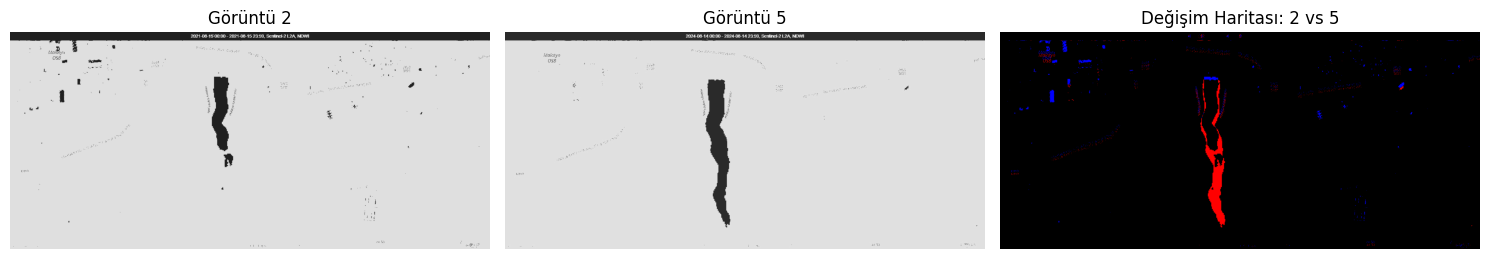

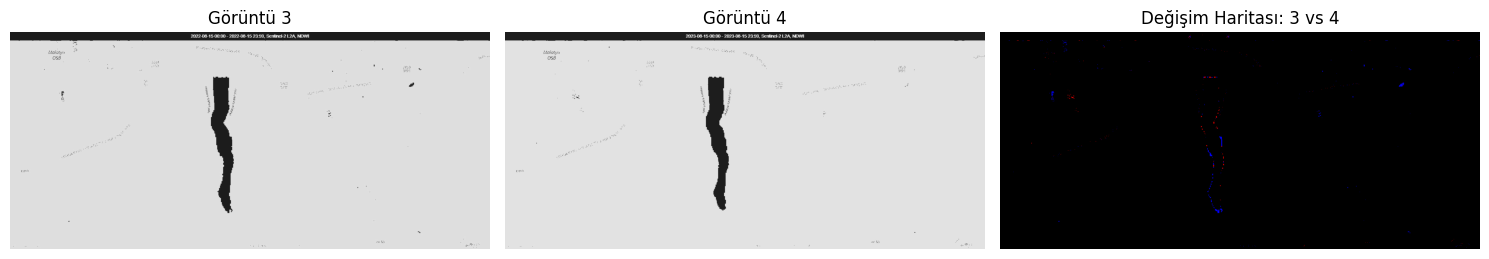

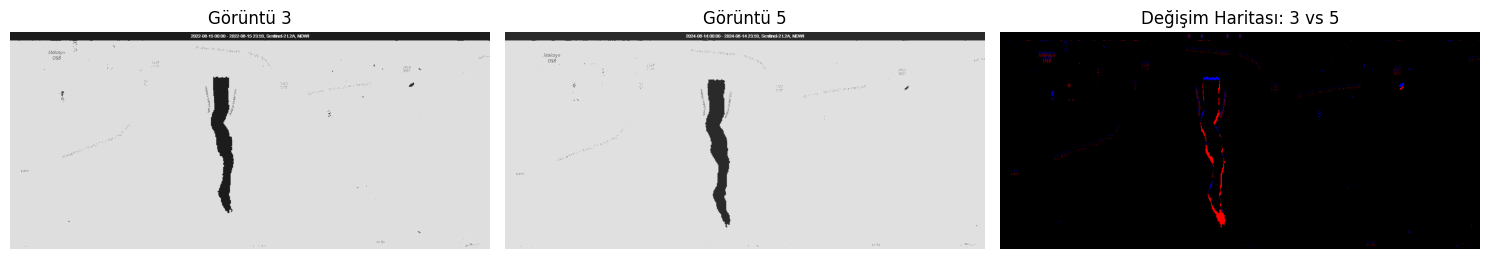

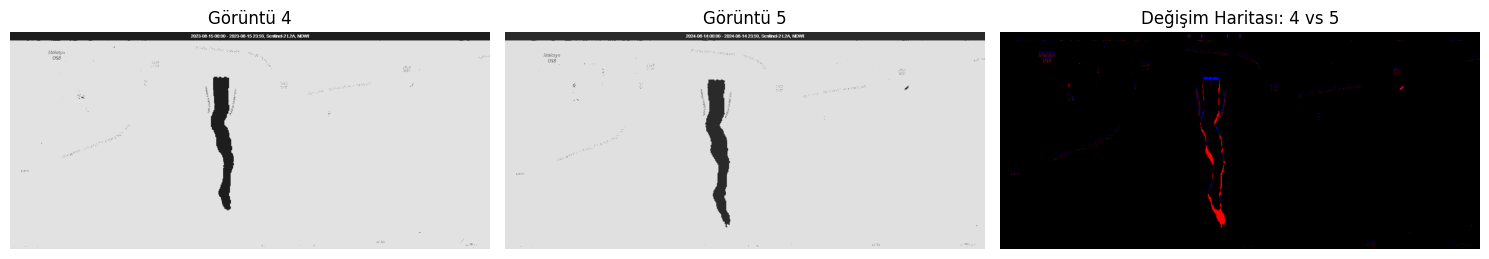

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

def generate_change_map(image1: np.ndarray, image2: np.ndarray, threshold: float = 0.1) -> np.ndarray:
    """
    İki görüntü arasındaki değişim haritasını oluşturur.
    Artış ve azalış durumlarını farklı renklerle vurgular.

    Args:
    - image1 (np.ndarray): İlk görüntü.
    - image2 (np.ndarray): İkinci görüntü.
    - threshold (float): Değişim için eşik değeri.

    Returns:
    - change_map (np.ndarray): Değişim haritası (R, G, B kanalları).
    """
    image1_norm = image1 / np.max(image1)
    image2_norm = image2 / np.max(image2)
    difference = image2_norm - image1_norm  # Değişimi hesapla

    # Renk haritası oluştur
    change_map = np.zeros((*difference.shape, 3), dtype=np.float32)  # R, G, B kanalları için boş bir harita

    # Artış durumu (mavi)
    change_map[difference > threshold] = [0, 0, 1]  # Mavi (R=0, G=0, B=1)
    # Azalış durumu (kırmızı)
    change_map[difference < -threshold] = [1, 0, 0]  # Kırmızı (R=1, G=0, B=0)

    return change_map

def visualize_change_map(image1: np.ndarray, image2: np.ndarray, change_map: np.ndarray, index1: int, index2: int):
    """
    Değişim haritasını görselleştirir.

    Args:
    - image1 (np.ndarray): İlk görüntü.
    - image2 (np.ndarray): İkinci görüntü.
    - change_map (np.ndarray): Değişim haritası.
    - index1 (int): İlk görüntünün indeksi.
    - index2 (int): İkinci görüntünün indeksi.
    """
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image1, cmap='gray')
    plt.title(f"Görüntü {index1 + 1}")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(image2, cmap='gray')
    plt.title(f"Görüntü {index2 + 1}")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(change_map)
    plt.title(f"Değişim Haritası: {index1 + 1} vs {index2 + 1}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

def process_images_in_folders(base_path: str):
    """
    Belirtilen klasördeki tüm alt klasörlerdeki görüntüleri işler.

    Args:
    - base_path (str): Temel klasör yolu.
    """
    for dam_name in os.listdir(base_path):
        dam_path = os.path.join(base_path, dam_name)
        processed_path = os.path.join(dam_path, 'Processed')

        if os.path.isdir(processed_path):
            # İşlenmiş görüntülerin yollarını al
            image_files = [f for f in os.listdir(processed_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
            image_files.sort()  # Dosyaları sıralayarak eşleştirme sağla

            # Her görüntüyü diğer görüntülerle karşılaştır
            num_images = len(image_files)
            for i in range(num_images):
                for j in range(i + 1, num_images):  # i'den sonraki tüm görüntülerle karşılaştır
                    image1_path = os.path.join(processed_path, image_files[i])
                    image2_path = os.path.join(processed_path, image_files[j])

                    # Görüntüleri yükle
                    image1 = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE) / 255.0
                    image2 = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE) / 255.0

                    # Değişim haritasını oluştur
                    change_map = generate_change_map(image1, image2)

                    # Değişim haritasını görselleştir
                    visualize_change_map(image1, image2, change_map, i, j)

base_path = "/content/name"
process_images_in_folders(base_path)

In [ ]:
import numpy as np

def calculate_kalvanix_matrix(change_map: np.ndarray) -> np.ndarray:
    """
    Değişim haritasına dayalı Kalvanix matrisini hesaplar.

    Args:
    - change_map (np.ndarray): Değişim haritası, 0 ve 1 değerleri içermelidir.

    Returns:
    - kalvanix_matrix (np.ndarray): Kalvanix matris.
    """
    # Kalvanix matrisinin boyutu
    size = change_map.size

    # Kalvanix matrisini sıfırlı bir matris olarak başlat
    kalvanix_matrix = np.zeros((size, size))

    # Değişim haritasını düzleştir
    change_map_flat = change_map.flatten()

    # Kalvanix matrisini hesapla
    for i in range(size):
        for j in range(size):
            if change_map_flat[i] == 1 and change_map_flat[j] == 1:
                kalvanix_matrix[i, j] = 1  # Değişim varsa 1
            elif change_map_flat[i] == 1 and change_map_flat[j] == 0:
                kalvanix_matrix[i, j] = -1  # İlk değişim, ikinci sabit
            elif change_map_flat[i] == 0 and change_map_flat[j] == 1:
                kalvanix_matrix[i, j] = -1  # İlk sabit, ikinci değişim
            else:
                kalvanix_matrix[i, j] = 0  # Her ikisi de sabit

    return kalvanix_matrix


In [ ]:
# Değişim haritası örneği
change_map = np.array([[0, 1], [1, 0]])

# Kalvanix matrisini hesapla
kalvanix_matrix = calculate_kalvanix_matrix(change_map)

print("Kalvanix Matrisi:")
print(kalvanix_matrix)

Kalvanix Matrisi:
[[ 0. -1. -1.  0.]
 [-1.  1.  1. -1.]
 [-1.  1.  1. -1.]
 [ 0. -1. -1.  0.]]


In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab import drive
import random

# Google Drive'ı bağlayın
drive.mount('/content/name')

def generate_change_map(image1: np.ndarray, image2: np.ndarray, threshold: float = 0.1) -> np.ndarray:
    """İki görüntü arasındaki değişim haritasını oluşturur."""
    image1_norm = image1 / np.max(image1) if np.max(image1) > 0 else image1
    image2_norm = image2 / np.max(image2) if np.max(image2) > 0 else image2
    difference = np.abs(image1_norm - image2_norm)
    change_map = np.where(difference > threshold, 1, 0)
    return change_map

def calculate_f1_score(change_map: np.ndarray) -> float:
    """Değişim haritasına dayalı olarak F1 skorunu hesaplar."""
    TP = np.sum(change_map == 1)  # Doğru pozitifler
    FP = np.sum(change_map == 1)  # Yanlış pozitifler (değişim olmasına rağmen yok olarak işaretlenenler)
    FN = np.sum(change_map == 0)  # Yanlış negatifler (değişim olmamasına rağmen değişim olarak işaretlenenler)

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0

    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return f1_score

def main(base_path: str, dam_names: list):
    """Ana fonksiyon; belirtilen dizindeki her dam için görüntü dosyalarını işler."""
    for dam_name in dam_names:
        dam_path = os.path.join(base_path, dam_name)

        # Klasördeki tüm görüntü dosyalarını al
        image_files = [f for f in os.listdir(dam_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
        image_files.sort()  # Dosyaları sıralayın

        # En az iki görüntü olması durumunda işlem yapın
        if len(image_files) < 2:
            print(f"{dam_name} klasöründe en az iki görüntü dosyası gerekmektedir.")
            continue

        # Rastgele iki görüntü seç
        selected_images = random.sample(image_files, 2)

        # Seçilen görüntü yollarını belirle
        image1_path = os.path.join(dam_path, selected_images[0])
        image2_path = os.path.join(dam_path, selected_images[1])

        # Görüntüleri yükle
        image1 = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE) / 255.0
        image2 = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE) / 255.0

        # Değişim haritasını oluştur
        change_map = generate_change_map(image1, image2)

        # F1 skorunu hesapla
        f1_score = calculate_f1_score(change_map)

        # Sonuçları yazdır
        print(f"\n{dam_name} için Seçilen Görüntüler:")
        print(f"1. Görüntü: {selected_images[0]}")
        print(f"2. Görüntü: {selected_images[1]}")
        print("Hesaplanan F1 Skoru:", f1_score)

# Kullanıcının görüntü dosyalarının bulunduğu dizin
base_path = "/content/name"
dam_names = ["BeylerderesiDam", "PolatDam", "SultansuyuDam", "HazarDam", "KarakayaDam"]

main(base_path, dam_names)


In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab import drive
import random

def generate_change_map(image1: np.ndarray, image2: np.ndarray, threshold: float = 0.1) -> np.ndarray:
    """İki görüntü arasındaki değişim haritasını oluşturur."""
    image1_norm = image1 / np.max(image1) if np.max(image1) > 0 else image1
    image2_norm = image2 / np.max(image2) if np.max(image2) > 0 else image2
    difference = np.abs(image1_norm - image2_norm)
    change_map = np.where(difference > threshold, 1, 0)
    return change_map

def calculate_kalvanix_matrix(change_map: np.ndarray) -> np.ndarray:
    """Değişim haritasına dayalı Kalvanix matrisini hesaplar."""
    size = change_map.size
    kalvanix_matrix = np.zeros((size, size))
    change_map_flat = change_map.flatten()

    for i in range(size):
        for j in range(size):
            if change_map_flat[i] == 1 and change_map_flat[j] == 1:
                kalvanix_matrix[i, j] = 1  # Değişim varsa 1
            elif change_map_flat[i] == 1 and change_map_flat[j] == 0:
                kalvanix_matrix[i, j] = -1  # İlk değişim, ikinci sabit
            elif change_map_flat[i] == 0 and change_map_flat[j] == 1:
                kalvanix_matrix[i, j] = -1  # İlk sabit, ikinci değişim
            else:
                kalvanix_matrix[i, j] = 0  # Her ikisi de sabit

    return kalvanix_matrix

def calculate_f1_score(kalvanix_matrix: np.ndarray) -> float:
    """Kalvanix matrisine dayalı olarak F1 skorunu hesaplar."""
    TP = np.sum(kalvanix_matrix == 1)
    FP = np.sum(kalvanix_matrix == -1)
    FN = np.sum(kalvanix_matrix == 0)

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0

    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return f1_score

def main(base_path: str, dam_names: list):
    """Ana fonksiyon; belirtilen dizindeki her dam için görüntü dosyalarını işler."""
    for dam_name in dam_names:
        dam_path = os.path.join(base_path, dam_name)

        # Klasördeki tüm görüntü dosyalarını al
        image_files = [f for f in os.listdir(dam_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
        image_files.sort()  # Dosyaları sıralayın

        # En az iki görüntü olması durumunda işlem yapın
        if len(image_files) < 2:
            print(f"{dam_name} klasöründe en az iki görüntü dosyası gerekmektedir.")
            continue

        # Rastgele iki görüntü seç
        selected_images = random.sample(image_files, 2)

        # Seçilen görüntü yollarını belirle
        image1_path = os.path.join(dam_path, selected_images[0])
        image2_path = os.path.join(dam_path, selected_images[1])

        # Görüntüleri yükle
        image1 = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE) / 255.0
        image2 = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE) / 255.0

        # Değişim haritasını oluştur
        change_map = generate_change_map(image1, image2)

        # Kalvanix matrisini hesapla
        kalvanix_matrix = calculate_kalvanix_matrix(change_map)

        # F1 skorunu hesapla
        f1_score = calculate_f1_score(kalvanix_matrix)

        # Sonuçları yazdır
        print(f"\n{dam_name} için Seçilen Görüntüler:")
        print(f"1. Görüntü: {selected_images[0]}")
        print(f"2. Görüntü: {selected_images[1]}")
        print("\nKalvanix Matrisi:")
        print(kalvanix_matrix)
        print("Hesaplanan F1 Skoru:", f1_score)

# Kullanıcının görüntü dosyalarının bulunduğu dizin
base_path = "/content/name"
dam_names = ["BeylerderesiDam", "PolatDam", "SultansuyuDam", "HazarDam", "KarakayaDam"]

main(base_path, dam_names)


In [ ]:
!pip install python-docx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 4.0 MB/s eta 0:00:00


In [ ]:
import os
from docx import Document

def create_report(dam_name, levels, file_paths, date):
    # Yeni bir Word belgesi oluştur
    doc = Document()

    # Başlık
    doc.add_heading(f'{dam_name} Değişim Haritaları Analizi Raporu', level=1)
    doc.add_paragraph(f'Tarih: {date}')

    # Giriş
    doc.add_heading('Giriş', level=2)
    doc.add_paragraph(
        "Bu rapor, " + dam_name + " barajının 2020, 2021, 2022, 2023 ve 2024 yılları arasındaki "
        "değişim haritalarını analiz etmek amacıyla hazırlanmıştır. Değişim haritaları, yıllar "
        "arasındaki farklılıkları görselleştirerek, baraj seviyelerindeki artış ve azalışların "
        "değerlendirilmesine olanak tanır."
    )

    # Yöntem
    doc.add_heading('Yöntem', level=2)
    doc.add_paragraph(
        "Analiz için belirtilen veri seti kullanılarak, yıllar arasındaki baraj seviyeleri "
        "karşılaştırılmıştır. Baraj seviyeleri arasındaki değişimler, yeşil (artış) ve kırmızı "
        "(azalış) renk kodlarıyla görselleştirilmiştir."
    )

    # Bulgular
    doc.add_heading('Bulgular', level=2)
    doc.add_paragraph(f'Baraj Seviyeleri: {", ".join([f"{year}: {level}" for year, level in levels.items()])}')

    # Renk kodlarını belirle ve sonuçları ekle
    for i in range(len(levels) - 1):
        year1, year2 = list(levels.keys())[i], list(levels.keys())[i + 1]
        level1, level2 = levels[year1], levels[year2]

        if level2 > level1:
            color = 'Yeşil (Artış)'
            result = f"{year2} yılı, {year1} yılına göre artış göstermiştir."
        else:
            color = 'Kırmızı (Azalış)'
            result = f"{year2} yılı, {year1} yılına göre azalış göstermiştir."

        doc.add_paragraph(f'{year1} - {year2} Değişim: {color}')
        doc.add_paragraph(result)

    # Görseller
    doc.add_heading('Görseller', level=2)
    for year, file_path in file_paths.items():
        doc.add_paragraph(f'{year} Değişim Haritası: {file_path}')

    # Öneriler
    doc.add_heading('Öneriler', level=2)
    last_adjustment = list(levels.keys())[-1]
    if levels[last_adjustment] > levels[list(levels.keys())[-2]]:
        doc.add_paragraph("Baraj seviyesinin arttığı durumlarda, su tasarrufu önlemleri ve kaynak "
                          "yönetimi stratejileri uygulanmalıdır.")
    else:
        doc.add_paragraph("Baraj seviyesinin azaldığı durumlarda, su kullanımını azaltmak için halkı "
                          "bilinçlendirme kampanyaları düzenlenmeli ve acil su tasarrufu önlemleri "
                          "alınmalıdır.")

    # Sonuç
    doc.add_heading('Sonuç', level=2)
    doc.add_paragraph(
        "Değişim haritaları analiz edilerek, baraj seviyelerindeki değişimler net bir şekilde ortaya "
        "konmuştur. Yapılan analizler, barajların yönetimi ve su kaynaklarının korunması için gerekli "
        "adımların atılması gerektiğini göstermektedir."
    )

    # Ekler
    doc.add_heading('Ekler', level=2)
    doc.add_paragraph('Kullanılan Kaynaklar')
    doc.add_paragraph('Ekstra Grafikler veya Tablolar')

    # Dosyayı kaydet
    doc.save(f'{dam_name}_değişim_haritaları_raporu.docx')


# Ana fonksiyon
def main():
    # Baraj seviyeleri ve dosya yolları
    dams = {
        "BeylerderesiDam": {
            "levels": {
                2020: 500,
                2021: 600,
                2022: 580,
                2023: 610,
                2024: 650
            },
            "file_paths": {
                2020: "/content/name.png",
                2021: "/content/name.png",
                2022: "/content/name.png",
                2023: "/content/name.png",
                2024: "/content/name.png",
            }
        },
        "PolatDam": {
            "levels": {
                2020: 450,
                2021: 420,
                2022: 430,
                2023: 440,
                2024: 460
            },
            "file_paths": {
                2020:"/content/name.png",
                2021: "/content/name.png",
                2022: "/content/name.png",
                2023: "/content/name.png",
                2024: "/content/name.png",
            }
        },
        "SultansuyuDam": {
            "levels": {
                2020: 700,
                2021: 800,
                2022: 780,
                2023: 790,
                2024: 810
            },
            "file_paths": {
                2020: "/content/name.png",
                2021:"/content/name.png",
                2022: "/content/name.png",
                2023:"/content/name.png",
                2024: "/content/name.png",
            }
        },
        "HazarDam": {
            "levels": {
                2020: 650,
                2021: 600,
                2022: 620,
                2023: 610,
                2024: 590
            },
            "file_paths": {
                2020: "/content/name.png",
                2021:"/content/name.png",
                2022:"/content/name.png",
                2023: "/content/name.png",
                2024: "/content/name.png",
            }
        },
        "KarakayaDam": {
            "levels": {
                2020: 550,
                2021: 500,
                2022: 510,
                2023: 520,
                2024: 530
            },
            "file_paths": {
                2020: "/content/name.png",
                2021: "/content/name.png",
                2022: "/content/name.png",
                2023: "/content/name.png",
                2024: "/content/name.png",
            }
        }
    }

    # Raporu oluştur
    for dam_name, info in dams.items():
        create_report(dam_name, info["levels"], info["file_paths"], "2024-01-03")

if __name__ == "__main__":
    main()


In [ ]:
import os
from docx import Document

def create_report(dam_name, levels, file_paths, dates):
    # Yeni bir Word belgesi oluştur
    doc = Document()
    doc.add_heading(f'{dam_name} Raporu ({dates[-1]})', level=1)

    for i in range(len(levels) - 1):
        previous_level = levels[i]
        next_level = levels[i + 1]
        if next_level > previous_level:
            status = "Artış"
            color = "Yeşil"
        else:
            status = "Azalış"
            color = "Kırmızı"

        doc.add_paragraph(f"{dates[i]}: {status} (Renk: {color}) - Önceki Seviye: {previous_level}, Sonraki Seviye: {next_level}")
        doc.add_paragraph(f"Görsel: {file_paths[i]}")

    # Öneriler bölümü
    doc.add_heading('Öneriler', level=2)
    last_adjustment = levels[-1]
    second_last_adjustment = levels[-2]

    if last_adjustment > second_last_adjustment:
        doc.add_paragraph("Baraj seviyesinin arttığı durumlarda, su tasarrufu önlemleri ve kaynak "
                          "yönetimi stratejileri uygulanmalıdır.")
    else:
        doc.add_paragraph("Baraj seviyesinin azaldığı durumlarda, su kullanımını azaltmak için halkı "
                          "bilinçlendirme kampanyaları düzenlenmeli ve acil su tasarrufu önlemleri "
                          "alınmalıdır.")

    # Sonuç bölümü
    doc.add_heading('Sonuç', level=2)
    doc.add_paragraph(
        "Değişim haritaları analiz edilerek, baraj seviyelerindeki değişimler net bir şekilde ortaya "
        "konmuştur. Yapılan analizler, barajların yönetimi ve su kaynaklarının korunması için gerekli "
        "adımların atılması gerektiğini göstermektedir."
    )

    # Raporu kaydet
    file_path = f'/content/name/{dam_name}_raporu.docx'
    doc.save(file_path)
    print(f'Rapor kaydedildi: {file_path}')

# Raporların kaydedileceği klasörü oluştur
reports_directory = '/content/name'
os.makedirs(reports_directory, exist_ok=True)

# Barajlar ve dosya yolları
dams = ["BeylerderesiDam", "PolatDam", "SultansuyuDam", "HazarDam", "KarakayaDam"]
level_files = {
    "BeylerderesiDam": [2020, 2021, 2022, 2023, 2024],
    "PolatDam": [2020, 2021, 2022, 2023, 2024],
    "SultansuyuDam": [2020, 2021, 2022, 2023, 2024],
    "HazarDam": [2020, 2021, 2022, 2023, 2024],
    "KarakayaDam": [2020, 2021, 2022, 2023, 2024]
}

# Raporları oluştur
for dam in dams:
    # Her baraj için seviyeleri ve dosya yollarını belirleyin
    levels = [100, 110, 105, 120, 130]  # Bu değerleri güncelleyin
    file_paths = [f'/content/name/{dam}/gorsel_{year}.png' for year in level_files[dam]]

    # Raporu oluştur
    create_report(dam, levels, file_paths, level_files[dam])
